### Emotion Predictions

In this notebook we are going to use the dataset that was obtained from [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp) and machine learning analyse the impact of n-grams in classifier scores using machine learning.

> Dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

First we are going to start by installing the packages that we are going to use in this notebook.

In [1]:
!pip install helperfns kaggle pigmenta -q

In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from helperfns.tables import tabulate_data
from pigmenta import PALETTES
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from helperfns.visualization import plot_complicated_confusion_matrix, plot_wordcloud, plot_classification_report
from collections import Counter

import warnings
import random
import json
import os

warnings.filterwarnings("ignore")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 2.2.2
numpy: 2.0.2


### SEED

Next we are going to set the `SEED` for all random operations in this notebook for reproducivity.

In [3]:
SEED = 23

np.random.seed(SEED)
random.seed(SEED)

### Data

Next we are going to download the dataset from Kaggle using the kaggle API.

> Dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [4]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

In [5]:
!kaggle datasets download praveengovi/emotions-dataset-for-nlp --unzip

Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 716MB/s]


Next we are going to read all the txt files into a single dataframe and add columns `text` and label.

In [6]:
train_df = pd.read_csv('train.txt', sep=';', names=['text', 'label'])
test_df = pd.read_csv('test.txt', sep=';', names=['text', 'label'])
val_df = pd.read_csv('val.txt', sep=';', names=['text', 'label'])

dataframe = pd.concat([train_df, test_df, val_df])
dataframe.head(2)

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness


Next we are going to drop `na` values if we have any.

In [7]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)

In the following plot we are going to visualize the distribution of emotions in the dataset.

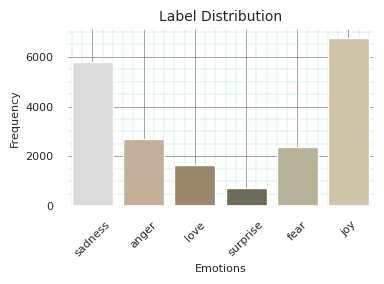

In [8]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(4, 3))
sns.countplot(data=dataframe, x="label", palette=PALETTES.coffee)
plt.xlabel("Emotions", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=45)
plt.title("Label Distribution", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()

In the following code cell we are going to split our dataset into `2` (train, test) sets and tabulate them.

In [9]:
train, test = train_test_split(dataframe, test_size=.20, random_state=SEED)

columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(train):,}"],
    ["TESTING", f"{len(test):,}"],
    ["TOTAL", f"{len(test) + len(train):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+----------+--------+
| Set      |  Total |
+----------+--------+
| TRAINING | 16,000 |
| TESTING  |  4,000 |
| TOTAL    | 20,000 |
+----------+--------+


Next we are going to extract features and labels from the each set.

In [10]:
# train
train_texts = train.text.values
train_labels = train.label.values
# test
test_texts = test.text.values
test_labels = test.label.values

In the following code cell we are going to get the most common words that are appearing each set of data.

In [11]:
train_text_counter = Counter()
for line in train_texts:
    train_text_counter.update(line.lower().split())

test_text_counter = Counter()
for line in test_texts:
    test_text_counter.update(line.lower().split())


In the following code cell we are then going to visualize the most common words that are appearing each set of data using wordclouds.

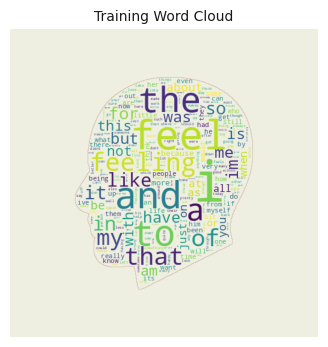

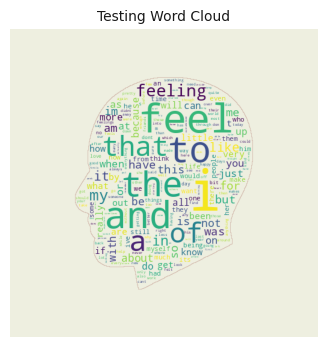

In [12]:
plot_wordcloud(
    train_text_counter, title="Training Word Cloud", mask="head", background_color=PALETTES.food[0], figsize=(4, 4),
    fontsize=10
)

plot_wordcloud(
    test_text_counter, title="Testing Word Cloud", mask="head", background_color=PALETTES.food[0], figsize=(4, 4),
    fontsize=10
)

From the dataset we can see that the most common words are `feel`, and `feeling` which indicate that indeed the dataset was based on human emotions.


In the following code cell we are going to transform our labels using the `LabelEncoder` to convert our labels to numerics.

In [13]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels.reshape(-1, 1))
y_test = label_encoder.transform(test_labels.reshape(-1, 1))

In [14]:
y_train[:2], y_test[:2]

(array([4, 4]), array([2, 2]))

Our clean sentence function is just convert the text to lowercase.

In [15]:
def clean_sentence(sent: str, lower: bool = True) -> str:
    sent = sent.lower() if lower else sent
    return sent

Now we can apply the helper function to clean our text for us.

In [16]:
train_texts = [clean_sentence(sent) for sent in train_texts]
test_texts = [clean_sentence(sent) for sent in test_texts]

train_texts[:2]

['i wonder how this feeling of being sentimental can help me through the agony of writing a report which dues tomorrow',
 'i have done quite a bit of traveling together and so know how to keep the other laughing when we re feeling defeated or stressed and the addition of audie and mona only multiplied the laughter']

In the following code cell we are going to check the best `classifier` and best `vectorizer` that produce the best fit for this emotional dataset.

#### Classifiers
1. `LogisticRegression`
2. `LinearSVC`
3. `MultinomialNB`
4. `RandomForestClassifier`

#### Vectorizers
1. `HashingVectorizer`
2. `CountVectorizer`
3. `HashingVectorizer`

In [17]:
data = []

vectorizers = [
    ("CountVectorizer", CountVectorizer(stop_words='english')),
    ("TfidfVectorizer", TfidfVectorizer(stop_words='english')),
    ("HashingVectorizer", HashingVectorizer(alternate_sign=False, stop_words='english'))
]

classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=100)),
    ("Linear SVM", LinearSVC()),
    ("Naive Bayes", MultinomialNB()),
    ("Random Forest", RandomForestClassifier(n_estimators=100))
]

for vec_name, vect in vectorizers:
    for clf_name, clf in classifiers:
        pipe = Pipeline([
            ("vect", vect),
            ("clf", clf)
        ])
        pipe.fit(train_texts, y_train)
        score = pipe.score(test_texts, y_test)
        data.append({"vectorizer": vec_name, "classifier": clf_name, "score": score})
        print(f"{vec_name} + {clf_name}: {score:.4f}")
    print()

scores_df = pd.DataFrame(data)
scores_df.head(2)

CountVectorizer + Logistic Regression: 0.8968
CountVectorizer + Linear SVM: 0.8918
CountVectorizer + Naive Bayes: 0.7947
CountVectorizer + Random Forest: 0.8885

TfidfVectorizer + Logistic Regression: 0.8728
TfidfVectorizer + Linear SVM: 0.8995
TfidfVectorizer + Naive Bayes: 0.6843
TfidfVectorizer + Random Forest: 0.8910

HashingVectorizer + Logistic Regression: 0.8688
HashingVectorizer + Linear SVM: 0.9045
HashingVectorizer + Naive Bayes: 0.5827
HashingVectorizer + Random Forest: 0.8798



,vectorizer,classifier,score
0,CountVectorizer,Logistic Regression,0.89675
1,CountVectorizer,Linear SVM,0.89175


In the following code cell we are going to visualize the scores for each classifier with respective vectorizer so that we can choose the best one.

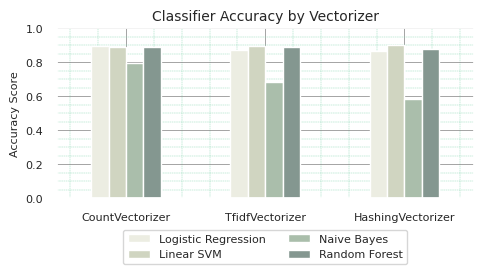

In [18]:
plt.figure(figsize=(5, 3))
sns.barplot(data=scores_df, x="vectorizer", y="score", hue="classifier", palette=PALETTES.food, width= .5)

plt.title("Classifier Accuracy by Vectorizer", fontsize=10)
plt.ylabel("Accuracy Score", fontdict={'fontsize': 8})
plt.xlabel("", fontdict={'fontsize': 8})
plt.ylim(0, 1.0)
plt.legend(fontsize=8,  loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()

Next we are going to define the  `n-gram` ranges that we are going to use to compare and evaluate the best classifier.

In [19]:
grams = []

for end in range(1, 5):
  for start in range(1, end + 1):
    label = f"{start}-{end}-gram" if start != end else f"{end}-gram"
    grams.append((label, (start, end)))

print(grams)

[('1-gram', (1, 1)), ('1-2-gram', (1, 2)), ('2-gram', (2, 2)), ('1-3-gram', (1, 3)), ('2-3-gram', (2, 3)), ('3-gram', (3, 3)), ('1-4-gram', (1, 4)), ('2-4-gram', (2, 4)), ('3-4-gram', (3, 4)), ('4-gram', (4, 4))]


Next we are going to train and evaluate the `LogisticRegression` with `CountVectorizer` using define `n-grams` ranges that was defined and see which ones perfomed better.

In [20]:
scores = []
for gram_name, gram in grams:
  pipe = Pipeline([
    ("vect", CountVectorizer(stop_words='english', ngram_range=gram)),
    ("clf", LogisticRegression(max_iter=100))
  ])
  pipe.fit(train_texts, y_train)
  score = pipe.score(test_texts, y_test)
  scores.append({"gram": gram_name, "score": score})
  print(f"{gram_name}: {score:.4f}")

1-gram: 0.8968
1-2-gram: 0.9065
2-gram: 0.7305
1-3-gram: 0.9032
2-3-gram: 0.7212
3-gram: 0.3905
1-4-gram: 0.9022
2-4-gram: 0.7117
3-4-gram: 0.3880
4-gram: 0.3325


Next we are going to create a dataframe of scores that we obtain after evaluating the best classifier using different n-grams range.

In [21]:
scores_df = pd.DataFrame(scores)
scores_df.head(10)

,gram,score
0,1-gram,0.89675
1,1-2-gram,0.90650
2,2-gram,0.73050
3,1-3-gram,0.90325
4,2-3-gram,0.72125
5,3-gram,0.39050
6,1-4-gram,0.90225
7,2-4-gram,0.71175
8,3-4-gram,0.38800
9,4-gram,0.33250


Then we visualize the scores by sorting them based on the best `n-gram` that has the highest score.

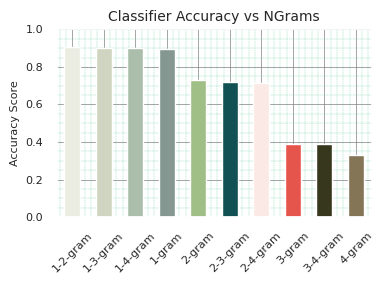

In [22]:
plt.figure(figsize=(4, 3))
sns.barplot(data=scores_df.sort_values("score", ascending=False),
            x="gram", y="score", palette=PALETTES.food, width= .5)

plt.title("Classifier Accuracy vs NGrams", fontsize=10)
plt.ylabel("Accuracy Score", fontdict={'fontsize': 8})
plt.xlabel("", fontdict={'fontsize': 8})
plt.ylim(0, 1.0)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

Next we are going to make predictions using our classifier that uses `(1, 2)` (unigrams and bigrams) as it appears to be the best classifier for emotions so that we can plot and visualize the confusion matrix.

In [23]:
y_true = y_test
pipe = Pipeline([
    ("vect", CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=100))
])
pipe.fit(train_texts, y_train)
y_preds = pipe.predict(test_texts)

In [24]:
labels = label_encoder.classes_

In the following code cell we are going to plot the confusion report based on the test dataset.

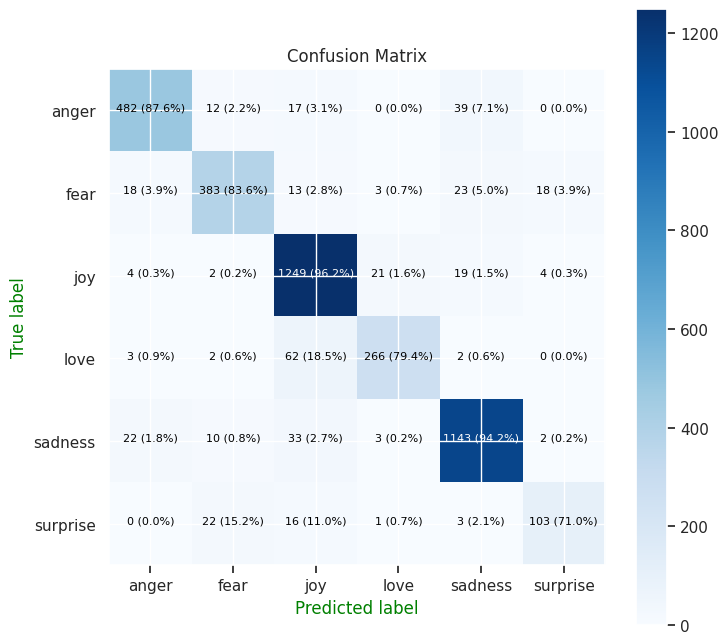

In [25]:
plot_complicated_confusion_matrix(y_true, y_preds,
  labels, fontsize=8, figsize=(8, 8)
)

In the following code cell we are going to plot the classification report based on the test dataset.

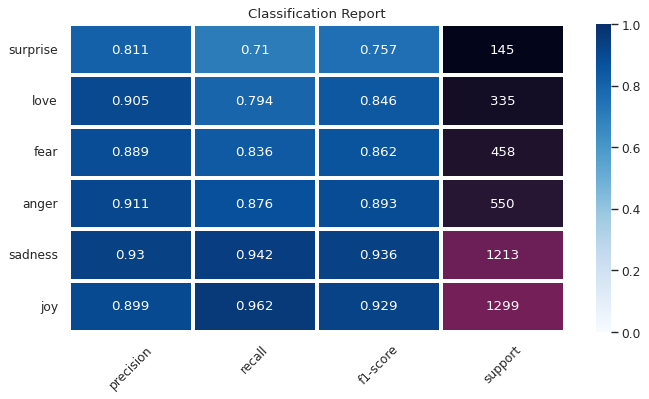

In [26]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels
)